In [2]:
# %reset -f
from random import sample, choices
import itertools
import pandas as pd
import numpy as np
from utils import *
from wavhandler import *
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import xgboost
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import logging
logger = logging.getLogger()
logger.propagate = False
logger.setLevel(logging.ERROR)
np.random.seed(0)

In [3]:
filename = 'mosquitos.csv'
df = pd.read_csv(os.path.join(TEMP_DATADIR, filename), delimiter=';', index_col=0)

In [4]:
print(df.shape)
df.sample(5)

(279566, 16)


,fname,pow0,pow1,pow2,fr0,fr1,fr2,damping_0,damping_1,damping_2,names,pathlen,fnamelen,temp,humd,label
101434,F170301_105922_039_G_050_T_25.2_H_51.1,0.153771,0.001028,0.000127,1148.437500,2298.828125,3447.265625,0.021259,0.011895,0.005666,/home/kalfasyan/data/insects/Wingbeats/Ae. alb...,9,9,25.2,51.1,Ae. albopictus
212333,F161220_191503_093_G_050,0.040789,0.009157,0.001568,392.578125,792.968750,1188.476562,0.034826,0.049261,0.017666,/home/kalfasyan/data/insects/Wingbeats/C. quin...,9,5,NaN,NaN,C. quinquefasciatus
161097,F170201_230126_093_G_050,0.139732,0.058833,0.010069,377.929688,747.070312,1094.726562,0.074935,0.035948,0.012935,/home/kalfasyan/data/insects/Wingbeats/An. ara...,9,5,NaN,NaN,An. arabiensis
62293,F170209_165233_242_G_050,0.147702,0.043849,0.014633,542.968750,1066.406250,1656.250000,0.046763,0.013736,0.017983,/home/kalfasyan/data/insects/Wingbeats/Ae. aeg...,9,5,NaN,NaN,Ae. aegypti
35574,F170211_085941_097_G_050,0.111529,0.063324,0.025073,447.265625,890.625000,1347.656250,0.081878,0.035088,0.020290,/home/kalfasyan/data/insects/Wingbeats/Ae. aeg...,9,5,NaN,NaN,Ae. aegypti


In [19]:
# CREATING DATE COLUMN
df['date'] = df['fname'].apply(lambda x: pd.to_datetime(x.split('_')[0] + x.split('_')[1], format='F%y%m%d%H%M%S'))
df['date'] = df.date.dt.to_period('d').apply(lambda x: x.strftime('%Y%m%d'))

0    20170209
1    20170209
Name: date, dtype: object


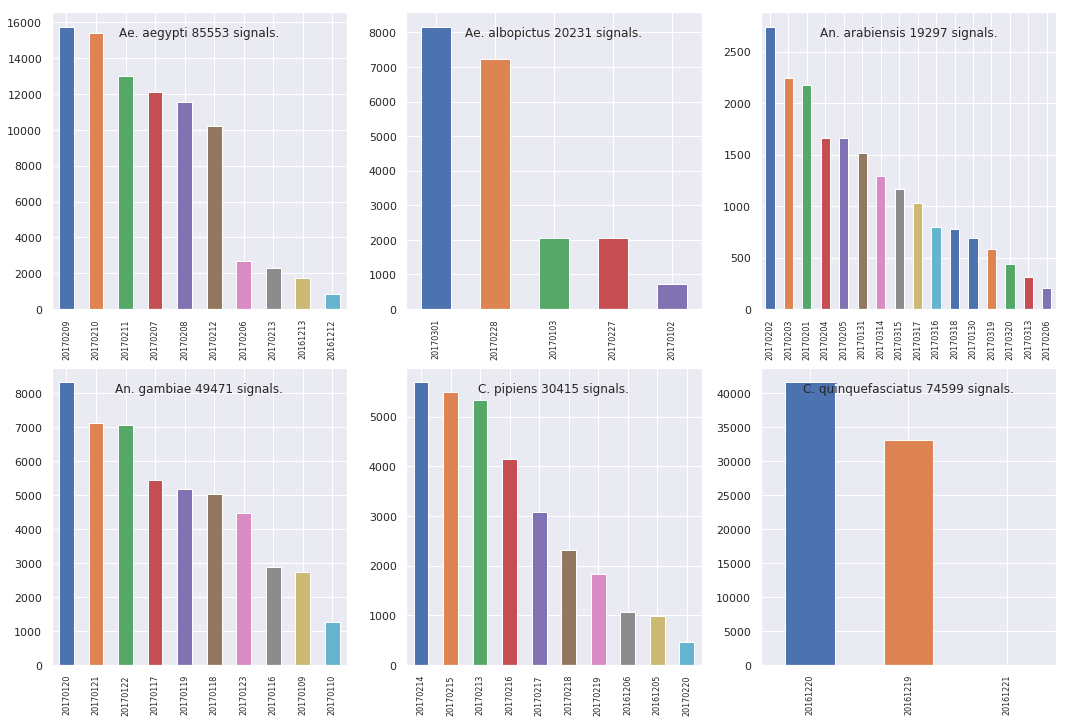

In [20]:
plt.figure(figsize=(18,12))
plt.tight_layout()
for q, (i, sub) in enumerate(df.groupby('label')):
    plt.subplot(2,3,q+1)
    plt.title(sub.label.unique()[0] +' '+ str(sub.shape[0])+' signals.', y=0.9)
    sub.date.value_counts().plot(kind='bar')
    plt.xticks(rotation=90, fontsize=8)

Example periods for class "An. gambiae": 	['20170120', '20170121', '20170122']
Example combinations for periods of class "An. gambiae": 	[('20170120', '20170120'), ('20170120', '20170121'), ('20170120', '20170122')]
Total nr. of combinations: 	55


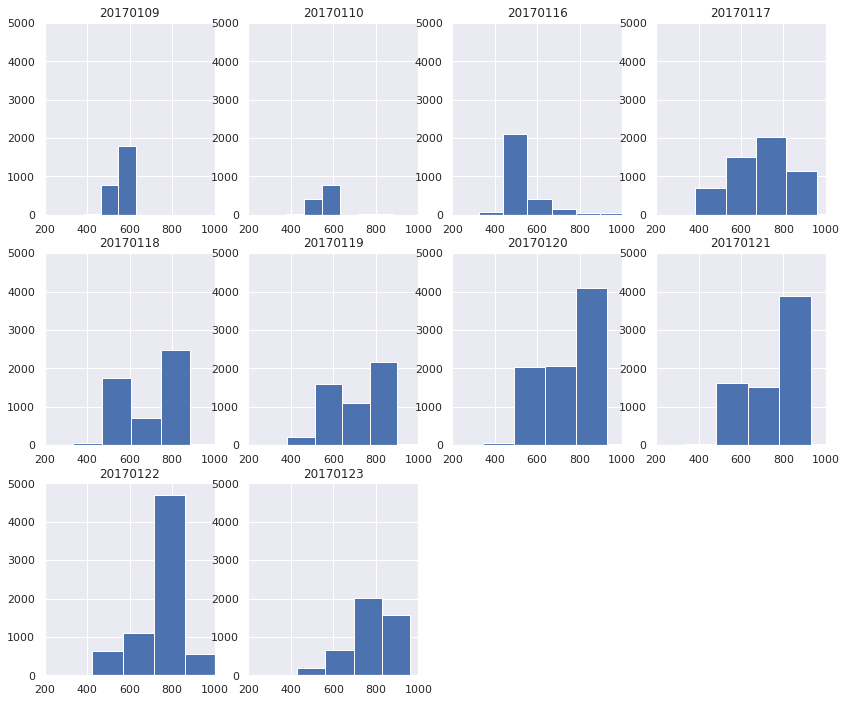

In [10]:
class_label = 'An. gambiae'
periods = df[df.label==class_label].date.value_counts().index.tolist()
periods = [periods[i] for i in range(len(periods))]
print('Example periods for class \"{}\": \t{}'.format(class_label, periods[:3]))

pair_combs = []
for i in itertools.combinations_with_replacement(periods, r=2):
    pair_combs.append(i)
print('Example combinations for periods of class \"{}\": \t{}'.format(class_label, pair_combs[:3]))
print('Total nr. of combinations: \t{}'.format(len(pair_combs)))

plt.figure(figsize=(14,12))
plt.tight_layout()
for i, (day, sub) in enumerate(df[df.label==class_label].groupby('date')):
    plt.subplot(3,4,i+1)
    plt.title(day)
    sub.fr0.hist()
    plt.xlim(200, 1000)
    plt.ylim(0,5000)